# Projeto 1: Fase de Data Preparation (CRISP-DM)

Neste Notebook iremos desenvolver 4 tarefas:
1.  **Data Selection:** Remover colunas desnecessárias.
2.  **Data Construction (Feature Engineering):** Criar colunas mais informativas.
3.  **Data Cleaning:** Tratar os *outliers* que identificámos na exploração.
4.  **Data Formatting:** Converter todos os dados para um formato numérico e escalado (Encoding e Scaling).

## 0. Importar Bibliotecas e Carregar Dados

Começamos por importar o `pandas` e o `numpy` para manipulação, e `sklearn` para as nossas ferramentas de preparação. Também carregamos o dataset original.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Configurar o estilo dos gráficos
sns.set_theme(style="whitegrid")
%matplotlib inline

# Carregar o dataset
try:
    df = pd.read_csv('../assets/ScreenTime vs MentalWellness.csv')
    print("Dataset original carregado com sucesso!")
    print(f"Shape original: {df.shape}")
except FileNotFoundError:
    print("Erro: Ficheiro 'ScreenTime vs MentalWellness.csv' não encontrado.")

# Criar uma cópia para a preparação (manter o df original)
df_prep = df.copy()
df_prep.head()

Dataset original carregado com sucesso!
Shape original: (400, 15)


,user_id,age,gender,occupation,work_mode,screen_time_hours,work_screen_hours,leisure_screen_hours,sleep_hours,sleep_quality_1_5,stress_level_0_10,productivity_0_100,exercise_minutes_per_week,social_hours_per_week,mental_wellness_index_0_100
0,U0001,33,Female,Employed,Remote,10.79,5.44,5.35,6.63,1,9.3,44.7,127,0.7,9.3
1,U0002,28,Female,Employed,In-person,7.40,0.37,7.03,8.05,3,5.7,78.0,74,2.1,56.2
2,U0003,35,Female,Employed,Hybrid,9.78,1.09,8.69,6.48,1,9.1,51.8,67,8.0,3.6
3,U0004,42,Male,Employed,Hybrid,11.13,0.56,10.57,6.89,1,10.0,37.0,0,5.7,0.0
4,U0005,28,Male,Student,Remote,13.22,4.09,9.13,5.79,1,10.0,38.5,143,10.1,0.0


## 1. Data Selection (Seleção de Dados)

Na fase de *Data Understanding*, vimos que `user_id` é apenas um identificador e por isso iremos retirá-lo.

In [9]:
if 'df_prep' in locals():
    # 'user_id' é um identificador único, não uma feature
    df_prep = df_prep.drop('user_id', axis=1)
    print("Coluna 'user_id' removida.")
    print(f"Novo shape: {df_prep.shape}")

Coluna 'user_id' removida.
Novo shape: (400, 14)


## 2. Data Construction (Feature Engineering)

Temos `screen_time_hours` (total), `work_screen_hours` (trabalho) e `leisure_screen_hours` (lazer). É provável que `screen_time_hours` inclua mais do que apenas trabalho e lazer (ex: ecrã de telemóvel genérico). 

Vamos criar uma nova feature chamada `other_screen_hours` para capturar este tempo "não explicado".

In [10]:
if 'df_prep' in locals():
    # Calcular o tempo de ecrã "outro"
    df_prep['other_screen_hours'] = df_prep['screen_time_hours'] - (df_prep['work_screen_hours'] + df_prep['leisure_screen_hours'])
    
    # Se 'other_screen_hours' for negativo, definimos como 0
    df_prep['other_screen_hours'] = df_prep['other_screen_hours'].clip(lower=0)
    
    print("Nova feature 'other_screen_hours' criada.")
    df_prep[['screen_time_hours', 'work_screen_hours', 'leisure_screen_hours', 'other_screen_hours']].head()

Nova feature 'other_screen_hours' criada.


**Nota:** Agora temos multicolinearidade (`screen_time_hours` é uma soma das outras três). Para a modelação, devemos usar `work_screen_hours`, `leisure_screen_hours` e `other_screen_hours`, e **remover `screen_time_hours`**. Faremos isso no passo final de seleção de features.

## 3. Data Cleaning (Tratamento de Outliers)

Na exploração (main.ipynb), vimos que `exercise_minutes_per_week` e `social_hours_per_week` (e talvez outras) tinham outliers significativos. Modelos como a Regressão Linear são sensíveis a outliers.

Vamos usar a técnica de **Capping (Winsorizing)**: limitar os valores ao percentil ou 5% e 95% para reduzir o seu impacto sem os eliminar.

Importante: `stress_level_0_10`, `sleep_quality_1_5` e `mental_wellness_index_0_100` são os nossos TARGETS e por isso não estão presentes no capping. Queremos que os modelos sejam capases de prever quando alguma dessas variáveis sejam realmente extremas.

Outliers tratados com Capping (Percentis 1% e 99%).


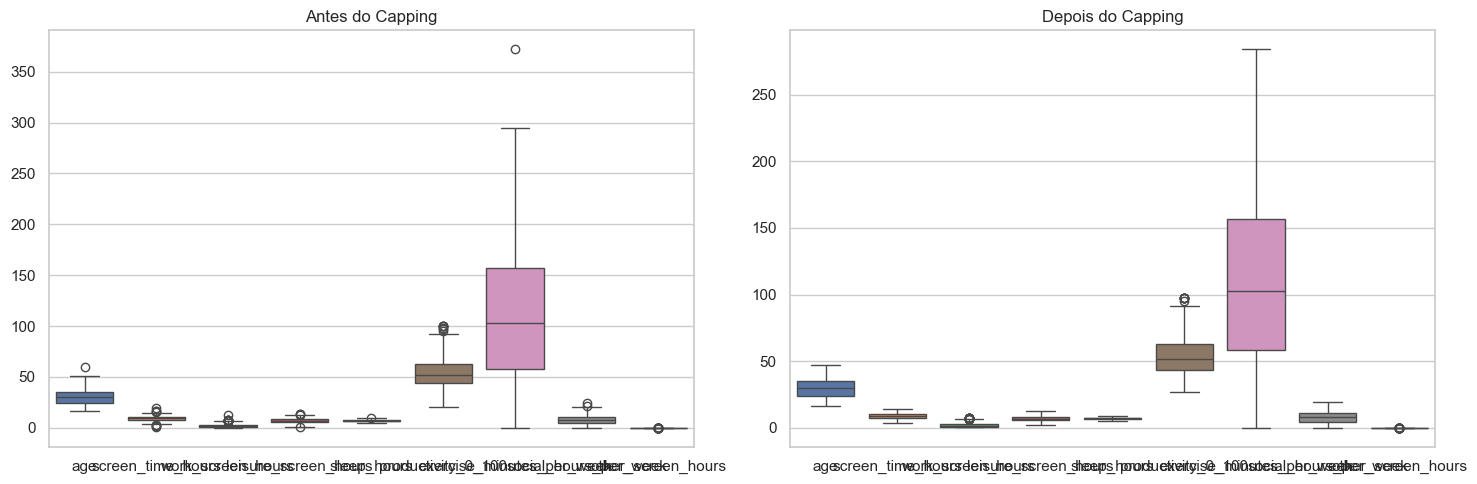

In [11]:
if 'df_prep' in locals():
    
    # Colunas identificadas com outliers na exploração (main.ipynb)
    # Excluímos os nossos TARGETS (stress, sleep_quality, mental_wellness)
    cols_to_cap = [
    'age', 
    'screen_time_hours', 
    'work_screen_hours', 
    'leisure_screen_hours', 
    'sleep_hours', 
    'productivity_0_100', 
    'exercise_minutes_per_week', 
    'social_hours_per_week',
    'other_screen_hours'
    ]
    
    # Plotar Boxplots Original
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_prep[cols_to_cap])
    plt.title("Antes do Capping")

    # Aplicar Capping
    for col in cols_to_cap:
        lower_limit = df_prep[col].quantile(0.01)
        upper_limit = df_prep[col].quantile(0.99)
        df_prep[col] = df_prep[col].clip(lower=lower_limit, upper=upper_limit)
        
    print("Outliers tratados com Capping (Percentis 1% e 99%).")

    # Plotar Boxplots alteradas
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_prep[cols_to_cap])
    plt.title("Depois do Capping")
    plt.tight_layout()
    plt.show()

## 4. Data Formatting (Encoding e Scaling)

Os modelos de ML não entendem texto. Precisamos de converter todas as colunas categóricas em números. Usaremos **One-Hot Encoding**.

Depois, muitas colunas têm escalas diferentes (`age` 18-65 vs `stress_level_0_10` 0-10). Isso pode enviesar os modelos. Aqui nós trataremos de normalizar tudo através do uso de **Standard Scaling** ou **Z-score**.

### 4.1 Encoding de Variáveis Categóricas

Vamos usar `pd.get_dummies` para converter `gender`, `occupation` e `work_mode` em colunas numéricas (0 ou 1). `drop_first=True` evita a "dummy variable trap" (multicolinearidade).

In [12]:
if 'df_prep' in locals():
    categorical_cols = ['gender', 'occupation', 'work_mode']
    
    # Guardar as colunas originais
    original_cols = df_prep.columns

    # NOTA IMPORTANTE: Usamos o 'drop_first=True' para evitar a multicolinearidade.
    # Isso significa que a primeira categoria de cada variável (ex: 'gender_Female', 'occupation_Employed', 'work_mode_Hybrid').
    # é removida e torna-se a "categoria de base" (baseline).
    # O modelo irá interpretar um participante como 'Female' quando 'gender_Male' == 0 E 'gender_Non-binary/Other' == 0.
    # Isto é crucial para a correta interpretação dos coeficientes do modelo na fase de Avaliação.
    
    # Aplicar One-Hot Encoding
    df_prep = pd.get_dummies(df_prep, columns=categorical_cols, drop_first=True)
    
    print("Variáveis Categóricas convertidas com One-Hot Encoding:")
    # Mostrar as novas colunas
    new_cols = [col for col in df_prep.columns if col not in original_cols]
    print(new_cols)
    
    df_prep.head()

Variáveis Categóricas convertidas com One-Hot Encoding:
['gender_Male', 'gender_Non-binary/Other', 'occupation_Retired', 'occupation_Self-employed', 'occupation_Student', 'occupation_Unemployed', 'work_mode_In-person', 'work_mode_Remote']


### 4.2 Scaling de Variáveis Numéricas

Agora que *todas* as colunas são numéricas, vamos escalar as *features* para terem média 0 e desvio padrão 1. 

**Importante:** Não escalamos os nossos TARGETS para não afetar a capacidade de predição do modelo.

In [13]:
if 'df_prep' in locals():
    target_cols = ['stress_level_0_10', 'sleep_quality_1_5', 'mental_wellness_index_0_100'] 
    
    # Obter a lista de todas as features.
    # Também removemos 'screen_time_hours' por ser redundante. Reveja o passo 2.
    features_to_scale = [col for col in df_prep.columns if col not in target_cols]
    if 'screen_time_hours' in features_to_scale:
        features_to_scale.remove('screen_time_hours')
        
    print(f"Total de features para escalar: {len(features_to_scale)}")
    print(features_to_scale)
    
    # Inicializar o Scaler
    scaler = StandardScaler()
    
    # Criar um novo DataFrame para os dados preparados
    df_final = df_prep.copy()
    
    # Aplicar o scaling apenas nas colunas de features
    df_final[features_to_scale] = scaler.fit_transform(df_final[features_to_scale])
    
    print("\nDados escalados com StandardScaler (Z-score):")
    df_final[features_to_scale].describe()

Total de features para escalar: 16
['age', 'work_screen_hours', 'leisure_screen_hours', 'sleep_hours', 'productivity_0_100', 'exercise_minutes_per_week', 'social_hours_per_week', 'other_screen_hours', 'gender_Male', 'gender_Non-binary/Other', 'occupation_Retired', 'occupation_Self-employed', 'occupation_Student', 'occupation_Unemployed', 'work_mode_In-person', 'work_mode_Remote']

Dados escalados com StandardScaler (Z-score):


## 5. Preparação Final para Modelação (X e y)

Para finalizar o Data Preparation, separamos o dataset em duas tabelas: features (`X`) e no vetor alvo (`y`).



In [14]:
if 'df_final' in locals():
    # X (Features)
    X = df_final[features_to_scale]
    
    # y (Targets
    y_stress = df_final['stress_level_0_10']
    y_sleep = df_final['sleep_quality_1_5']
    
    print("Matriz de Features X (Head):")
    display(X.head())
    
    print("\nVetor Alvo y_stress (Head):")
    display(y_stress.head())
    
    print("\nVetor Alvo y_sleep (Head):")
    display(y_sleep.head())

Matriz de Features X (Head):


,age,work_screen_hours,leisure_screen_hours,sleep_hours,productivity_0_100,exercise_minutes_per_week,social_hours_per_week,other_screen_hours,gender_Male,gender_Non-binary/Other,occupation_Retired,occupation_Self-employed,occupation_Student,occupation_Unemployed,work_mode_In-person,work_mode_Remote
0,0.447784,1.740096,-0.683112,-0.457887,-0.647154,0.252673,-1.482116,-0.313328,-0.859727,-0.142857,-0.190445,-0.356034,-0.604308,-0.269047,-0.592749,1.290994
1,-0.236399,-0.958848,0.086154,1.240969,1.593545,-0.514327,-1.193276,-0.313328,-0.859727,-0.142857,-0.190445,-0.356034,-0.604308,-0.269047,1.687055,-0.774597
2,0.721457,-0.575566,0.846263,-0.637344,-0.169407,-0.615628,0.023978,-0.313328,-0.859727,-0.142857,-0.190445,-0.356034,-0.604308,-0.269047,-0.592749,-0.774597
3,1.679313,-0.857704,1.707109,-0.146829,-1.165273,-1.585231,-0.450545,-0.313328,1.163160,-0.142857,-0.190445,-0.356034,-0.604308,-0.269047,-0.592749,-0.774597
4,-0.236399,1.021442,1.047737,-1.462845,-1.064341,0.484220,0.457238,-0.313328,1.163160,-0.142857,-0.190445,-0.356034,1.654786,-0.269047,-0.592749,1.290994



Vetor Alvo y_stress (Head):


0     9.3
1     5.7
2     9.1
3    10.0
4    10.0
Name: stress_level_0_10, dtype: float64


Vetor Alvo y_sleep (Head):


0    1
1    3
2    1
3    1
4    1
Name: sleep_quality_1_5, dtype: int64

# Conclusão

O *Data Preparation* está concluído. 

Temos agora:
- `X`: Um DataFrame/Matriz contendo *features* limpas, tratadas para outliers, e formatadas.
- `y_stress`: O nosso vetor alvo para o primeiro modelo de regressão.
- `y_sleep`: O nosso vetor alvo para o segundo modelo de regressão.